## Data & Imports

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels import regression
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split

In [2]:
# Remove aggregate rows, replace NaN with 0

puf = pd.read_csv('puf2011.csv')

puf = puf[(puf['RECID'] != 999996) &
          (puf['RECID'] != 999997) &
          (puf['RECID'] != 999998) &
          (puf['RECID'] != 999999)
         ]
           
puf = puf.fillna(0)

# Constant column

puf['constant'] = 1

#  MARS to K - 1 dummies

puf[['MARS2', 'MARS3', 'MARS4']] = pd.get_dummies(puf['MARS'], drop_first = True)

# E19800 and E20100 combined in CPS

puf['E19800_E20100'] = puf['E19800'] + puf['E20100']

# Categorical dependent variable for 1st stage, as string and as dummies

puf['sign'] = np.where(puf['P22250'] == 0, 'zer', np.where(puf['P22250'] > 0, 'pos', 'neg'))


# Variables in both puf and cps (excluding weights, E00650)

predictors =  [
              'DSI', 'EIC', 'MARS2', 'MARS3', 'MARS4', 'XTOT', 
              'E00200', 'E00300', 'E00400', 'E00600', 'E00800', 'E00900', 
              'E01400', 'E01500', 'E01700', 'E02100', 'E02300', 'E02400', 
              'E03150', 'E03210', 'E03240', 'E03270', 'E03300', 'E17500', 
              'E18400', 'E18500', 'E19200', 'E19800_E20100','E20400', 
              'E32800', 'F2441', 'N24', 'E01100'
              ]

discretes = ['DSI', 'EIC', 'MARS2', 'MARS3', 'MARS4', 'XTOT', 'F2441', 'N24']

# Create log columns of continuous predictors/response 

logs = []

for i in predictors + ['P22250']:
   
    if i not in discretes:
        
        if puf[i].min() >= 1:
            
            puf['log_' + i] = np.log(puf[i])
       
        puf['log_' + i] = np.log(puf[i] - puf[i].min() + 1)
          
        logs.append('log_' + i)

keep = ['RECID', 'AGIR1', 'P22250', 'sign', 'constant'] + predictors + logs

puf = puf[keep]

np.random.seed(100)

train, test = train_test_split(puf.copy(), test_size=0.2)

# Drop two negative outliers

train = train.drop(labels = [46928, 143309])

# Sub-df's where P22250 > 0 or < 0 pos or neg for 2nd stage imputation

pos_train = train.copy()[train.copy()['P22250'] > 0]
neg_train = train.copy()[train.copy()['P22250'] < 0]

pos_test =  test.copy()[test.copy()['P22250'] > 0]
neg_test =  test.copy()[test.copy()['P22250'] < 0]


## One-stage prediction: Random Forests (RF)

In [3]:
# 100 estimators
N_ESTIMATORS = 100
rf = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS, 
                                    min_samples_leaf=1, random_state=3, 
                                    verbose=True, 
                                    n_jobs=-1)  # Use maximum number of cores.

rf.fit(train[predictors], train['P22250'])

rf_predictions = rf.predict(test[predictors])

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


rf_preds = array of estimators

In [4]:
rf_preds = []
for estimator in rf.estimators_:
    rf_preds.append(estimator.predict(test[predictors]))
rf_preds = np.array(rf_preds).transpose()  # One row per record.

## One-stage scoring: RF

### Log-loss

We can calculate the RF model's predicted probability for each sign (and thus its log-loss) using the % of estimators predicting that sign for each observation.

Note: `metrics.log_loss()` assumes that the order of the columns of predicted probabilities correspond to their categories' alphabetical order. Our categories are `'neg'`, `'zer'` and `'pos'`, which have the alphabetical order of `'neg'`, `'pos'`, `'zer'`, thus they appear in that order in `rf_pred_proba` as `[preds_neg, preds_pos, preds_zer]`

In [5]:
preds_neg = np.sum(rf_preds < 0, axis=1) / 100
preds_zer = np.sum(rf_preds == 0, axis=1) / 100
preds_pos = np.sum(rf_preds > 0, axis=1) / 100

rf_pred_proba = list(map(list, zip(*[preds_neg, preds_pos, preds_zer])))

metrics.log_loss(test['sign'], rf_pred_proba)

0.6897766709507555

### RMSE

In [6]:
(test['P22250'] - rf_predictions).pow(2).mean()** 0.5

411117.31955911306

## Two-stage Prediction: mnlogit + OLS
### 1st stage: mnlogit 

In [7]:
# Formula = sign ~ DSI + EIC + ... + F2441 + N24
# It turns out that only 1.3% of E01100 is non-zero, which could be why 
# including it as a predictor breaks mnlogit. E01100 thus excluded.

predictors_mnl = predictors[:-1]
formula = 'sign ~ ' + ' + '.join(predictors_mnl)
mnl_fit = smf.mnlogit(formula = formula, data = train).fit()
summary = mnl_fit.summary()
summary

Optimization terminated successfully.
         Current function value: 0.577166
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:               131026
Model:                        MNLogit   Df Residuals:                   130960
Method:                           MLE   Df Model:                           64
Date:                Tue, 14 Aug 2018   Pseudo R-squ.:                  0.2373
Time:                        15:22:59   Log-Likelihood:                -75624.
converged:                       True   LL-Null:                       -99159.
                                        LLR p-value:                     0.000
=================================================================================
  y=sign[pos]       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.1281      0.034     -3.727      0.000      -0.195      -0.061
DSI               0.1601      0.147      1.092      0.275      -0.127       0.447
EIC              -0.2173      0.118     -1.848      0.065      -0.448       0.013
MARS2            -0.0308      0.041     -0.752      0.452      -0.111       0.050
MARS3            -0.0040      0.080     -0.051      0.959      -0.160       0.152
MARS4             0.0132      0.079      0.167      0.868      -0.142       0.169
XTOT             -0.0009      0.019     -0.047      0.963      -0.037       0.035
E00200        -1.787e-08   7.39e-09     -2.419      0.016   -3.23e-08   -3.39e-09
E00300         9.886e-08    3.2e-08      3.086      0.002    3.61e-08    1.62e-07
E00400        -1.294e-07   5.07e-08     -2.550      0.011   -2.29e-07      -3e-08
E00600         -1.73e-08   1.76e-08     -0.980      0.327   -5.19e-08    1.73e-08
E00800        -1.384e-05   1.03e-05     -1.350      0.177   -3.39e-05    6.26e-06
E00900        -3.552e-08   3.51e-08     -1.011      0.312   -1.04e-07    3.34e-08
E01400        -5.094e-09   6.17e-08     -0.083      0.934   -1.26e-07    1.16e-07
E01500        -5.403e-09   2.02e-08     -0.267      0.789    -4.5e-08    3.42e-08
E01700        -7.231e-08   1.64e-07     -0.441      0.659   -3.93e-07    2.49e-07
E02100         2.644e-08   1.16e-07      0.228      0.819   -2.01e-07    2.53e-07
E02300        -1.062e-05   6.17e-06     -1.721      0.085   -2.27e-05    1.48e-06
E02400        -3.856e-06   9.18e-07     -4.200      0.000   -5.66e-06   -2.06e-06
E03150         5.022e-07   6.84e-06      0.073      0.941   -1.29e-05    1.39e-05
E03210        -6.289e-05      0.000     -0.623      0.533      -0.000       0.000
E03240        -3.404e-07   1.68e-07     -2.029      0.042   -6.69e-07   -1.16e-08
E03270         5.258e-06   1.77e-06      2.963      0.003    1.78e-06    8.74e-06
E03300        -3.957e-07   4.66e-07     -0.849      0.396   -1.31e-06    5.17e-07
E17500        -8.072e-07   7.62e-07     -1.060      0.289    -2.3e-06    6.86e-07
E18400         3.184e-09   3.42e-08      0.093      0.926   -6.39e-08    7.02e-08
E18500        -3.136e-07   4.36e-07     -0.720      0.472   -1.17e-06     5.4e-07
E19200         3.845e-07   1.36e-07      2.824      0.005    1.18e-07    6.51e-07
E19800_E20100 -2.573e-09    2.3e-08     -0.112      0.911   -4.77e-08    4.26e-08
E20400        -3.691e-08   1.02e-07     -0.361      0.718   -2.37e-07    1.64e-07
E32800        -6.243e-06   2.82e-05     -0.222      0.825   -6.15e-05     4.9e-05
F2441             0.0010      0.058      0.018      0.986      -0.113       0.115
N24               0.0457      0.020      2.242      0.025       0.006       0.086
---------------------------------------------------------------------------------
  y=sign[zer]       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.0321      0.028    107.

Extracting probabilities

In [8]:
# mnlogit.fit.predict() bug causes columns to lose labels. However according to the documentation 
# column 0 = omitted category (which is 'neg' as it is the first alphabetically). We can infer that
# the most likely column, column 2, is 'zer', thus column 1 = 'pos'

mnl_pred_proba = mnl_fit.predict(test[predictors_mnl])
mnl_pred_proba.rename(columns={0: 'neg', 1: 'pos', 2: 'zero'}, inplace = True)

# Note that columns are alphabetically ordered, so this will work for metrics.log_loss()

mnl_pred_proba.head()

,neg,pos,zero
43632,0.009440,0.007075,0.983485
55268,0.150469,0.135993,0.713538
155007,0.403581,0.321199,0.275220
46437,0.061226,0.050625,0.888149
30152,0.143453,0.121501,0.735047


Stochastic sign imputation function

In [9]:
# Arguments = 'runif': a random uniform in [0,1], and 'probs': a vector of predicted probabilities for each sign. 
# Output = predicted sign if associated CDF value > runif.
# probs[0] = P(neg), probs[1] = P(pos), probs[2] = P(zer)

def stoch_imp(runif, probs):
    
    if runif < probs[0]:
        return ('neg')
    
    elif runif < probs[0] + probs[1]:
        return ('pos')
    
    else:
        return ('zer')

# Creates vector of runifs the length of puf, to be used in each imputation.

np.random.seed(1995)
runifs = np.random.uniform(size = len(test))

In [10]:
mnl_pred_sign = []

count = 0

for i in runifs:
    probs = mnl_pred_proba.iloc[count]
    mnl_pred_sign.append(stoch_imp(i, probs))
    count += 1

Sign imputation

In [11]:
test['sign_p'] = mnl_pred_sign

#neg/pos_p_test = test subsets predicted by mnlogit to be negative/positive

neg_p_test = test.copy()[test.copy()['sign_p'] == 'neg']
pos_p_test = test.copy()[test.copy()['sign_p'] == 'pos']

## Two-stage scoring: mnlogit
### Log-loss

In [12]:
metrics.log_loss(test['sign'], mnl_pred_proba)

0.5836617256539257

## 2nd stage: OLS

#### Positive data

In [13]:
# Predictors included are those with p values <= 0.1

ols_pos_predictors = [
                      'constant', 'MARS2', 'F2441', 'N24', 'log_E00200',
                      'log_E00300', 'log_E00400', 'log_E00600', 'E00900',
                      'log_E01500', 'E02400', 'log_E03240', 'E03270',
                      'log_E03300', 'log_E17500', 'log_E18400', 'log_E18500',
                      'log_E19200', 'log_E19800_E20100', 'log_E20400'
                     ]

ols_pos_fit = sm.OLS(pos_train['log_P22250'], pos_train[ols_pos_predictors]).fit()
summary = ols_pos_fit.summary()

summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_P22250   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     35.48
Date:                Tue, 14 Aug 2018   Prob (F-statistic):          8.55e-128
Time:                        15:23:03   Log-Likelihood:                 61122.
No. Observations:               15800   AIC:                        -1.222e+05
Df Residuals:                   15780   BIC:                        -1.221e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
constant             18.6419      0.000   1.16e+05      0.000      18.642      18.642
MARS2                -0.0005      0.000     -4.188      0.000      -0.001      -0.000
F2441                -0.0002      0.000     -1.768      0.077      -0.000     2.5e-05
N24                   0.0003   4.79e-05      5.454      0.000       0.000       0.000
log_E00200        -3.606e-05   8.61e-06     -4.187      0.000   -5.29e-05   -1.92e-05
log_E00300            0.0002    1.5e-05     12.893      0.000       0.000       0.000
log_E00400        -3.266e-05   1.04e-05     -3.148      0.002    -5.3e-05   -1.23e-05
log_E00600         9.789e-05   1.58e-05      6.210      0.000     6.7e-05       0.000
E00900            -3.534e-10   1.37e-10     -2.575      0.010   -6.22e-10   -8.43e-11
log_E01500        -1.876e-05   8.44e-06     -2.224      0.026   -3.53e-05   -2.23e-06
E02400            -6.391e-09   3.58e-09     -1.785      0.074   -1.34e-08    6.26e-10
log_E03240        -5.125e-05   1.52e-05     -3.365      0.001   -8.11e-05   -2.14e-05
E03270             2.709e-08   6.82e-09      3.975      0.000    1.37e-08    4.04e-08
log_E03300        -3.966e-05   1.37e-05     -2.904      0.004   -6.64e-05   -1.29e-05
log_E17500        -3.875e-05   1.87e-05     -2.077      0.038   -7.53e-05   -2.18e-06
log_E18400         2.361e-05   1.02e-05      2.307      0.021    3.55e-06    4.37e-05
log_E18500        -8.303e-05   1.69e-05     -4.920      0.000      -0.000   -4.99e-05
log_E19200         6.695e-05   1.12e-05      5.960      0.000    4.49e-05     8.9e-05
log_E19800_E20100  3.368e-05   1.62e-05      2.082      0.037    1.97e-06    6.54e-05
log_E20400         4.084e-05   1.19e-05      3.418      0.001    1.74e-05    6.43e-05
==============================================================================
Omnibus:                    38405.648   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        661684037.771
Skew:                          25.403   Prob(JB):                         0.00
Kurtosis:                    1004.253   Cond. No.                     1.24e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Negative data

In [14]:
ols_neg_predictors = [
                      'constant', 'MARS3', 'MARS4', 'log_E00200', 'log_E00300',
                      'log_E00400', 'log_E00600', 'log_E00900', 'log_E03210',
                      'log_E03270', 'log_E17500', 'log_E18400', 'log_E19200',
                     'log_E19800_E20100'
                     ] 
ols_neg_fit = sm.OLS(neg_train['log_P22250'], neg_train[ols_neg_predictors]).fit()
summary = ols_neg_fit.summary()

summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_P22250   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     18.64
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           5.25e-44
Time:                        15:23:03   Log-Likelihood:                 71202.
No. Observations:               18598   AIC:                        -1.424e+05
Df Residuals:                   18584   BIC:                        -1.423e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
constant             18.4684      0.067    274.766      0.000      18.337      18.600
MARS3                -0.0011      0.000     -4.056      0.000      -0.002      -0.001
MARS4                -0.0006      0.000     -2.159      0.031      -0.001   -5.24e-05
log_E00200         3.726e-05   7.59e-06      4.908      0.000    2.24e-05    5.21e-05
log_E00300        -9.291e-05   1.47e-05     -6.320      0.000      -0.000   -6.41e-05
log_E00400         3.854e-05    9.9e-06      3.892      0.000    1.91e-05     5.8e-05
log_E00600           -0.0001   1.55e-05     -6.960      0.000      -0.000   -7.76e-05
log_E00900            0.0101      0.004      2.600      0.009       0.002       0.018
log_E03210           -0.0001    6.4e-05     -1.741      0.082      -0.000     1.4e-05
log_E03270         3.825e-05   1.07e-05      3.584      0.000    1.73e-05    5.92e-05
log_E17500          4.68e-05   1.74e-05      2.692      0.007    1.27e-05    8.09e-05
log_E18400          2.08e-05   9.56e-06      2.176      0.030    2.06e-06    3.95e-05
log_E19200        -4.709e-05   9.63e-06     -4.892      0.000    -6.6e-05   -2.82e-05
log_E19800_E20100  3.901e-05   1.34e-05      2.909      0.004    1.27e-05    6.53e-05
==============================================================================
Omnibus:                    47463.812   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1187646059.051
Skew:                         -28.687   Prob(JB):                         0.00
Kurtosis:                    1239.657   Cond. No.                     4.73e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Continuous value imputation

## Two-stage scoring: mnlogit + OLS

In [15]:
# Log predictions created for observations in test subsets predicted to be negative/positive

log_neg_predictions = ols_neg_fit.predict(neg_p_test[ols_neg_predictors])
log_pos_predictions = ols_pos_fit.predict(pos_p_test[ols_pos_predictors])

# Transform via e^(Y-hat) + min(P22250) - 1

neg_predictions = np.exp(log_neg_predictions) + puf['P22250'].min() - 1
pos_predictions = np.exp(log_pos_predictions) + puf['P22250'].min() - 1

# Combine neg/pos predictions into dataframe the size of len(test) - len(observations in test predicted to be 0) 
# Keep row labels from test

ols_predictions = pd.concat([neg_predictions, pos_predictions], axis = 0).to_frame()

# Create new column in test using combined predictions. Predictions will be assinged to their rows
# using row labels. All rows not in ols_predictions will be given a NaN. These rows are those 
# which were not in neg_p_test or pos_pos_test, thus they were predicted by mnlogit to be 0.

test['mnlOLS_p'] = ols_predictions
test['mnlOLS_p'] = test['mnlOLS_p'].fillna(0)

### RMSE

In [16]:
(test['P22250'] - test['mnlOLS_p']).pow(2).mean()**0.5

389051.8348869253

## 2nd stage: LassoCV

#### Positive data

In [17]:
lasso_pos_fit = linear_model.LassoCV(cv = 10, n_jobs = -1).fit(pos_train[discretes + logs[:-2]], pos_train['log_P22250'])

Final model coefficients

In [18]:
dict(zip(discretes + logs[:-2], lasso_pos_fit.coef_))

{'DSI': 0.0,
 'EIC': 0.0,
 'F2441': -0.0,
 'MARS2': -0.00032751134356181084,
 'MARS3': 0.0,
 'MARS4': 0.0,
 'N24': 0.00023098917485210553,
 'XTOT': 0.0,
 'log_E00200': -4.46748760123711e-05,
 'log_E00300': 0.0001991003530821231,
 'log_E00400': -3.110372093742216e-05,
 'log_E00600': 9.726399069653684e-05,
 'log_E00800': -0.0,
 'log_E00900': -0.0,
 'log_E01400': -4.3677780247846333e-07,
 'log_E01500': -2.394925433018095e-05,
 'log_E01700': 9.368038435311897e-06,
 'log_E02100': -0.0,
 'log_E02300': 2.280269632303554e-05,
 'log_E02400': -3.360422128390319e-05,
 'log_E03150': -1.1914614753270806e-05,
 'log_E03210': 6.0831189544880714e-05,
 'log_E03240': -4.47254817702592e-05,
 'log_E03270': 5.8485439903419715e-06,
 'log_E03300': -3.19474565204911e-05,
 'log_E17500': -3.553748594388098e-05,
 'log_E18400': 2.3600246163568107e-05,
 'log_E18500': -7.878391526544469e-05,
 'log_E19200': 6.48696436548076e-05,
 'log_E19800_E20100': 3.245634423666179e-05,
 'log_E20400': 3.9855095436602445e-05,
 'log

#### Negative data

In [19]:
lasso_neg_fit = linear_model.LassoCV(cv = 10, n_jobs = -1).fit(neg_train[discretes + logs[:-2]], neg_train['log_P22250'])

Final model coefficients

In [20]:
dict(zip(discretes + logs[:-2], lasso_neg_fit.coef_))

{'DSI': 0.0,
 'EIC': -0.0,
 'F2441': 0.0,
 'MARS2': 0.0,
 'MARS3': -0.0,
 'MARS4': -0.0,
 'N24': 0.0,
 'XTOT': 0.0,
 'log_E00200': 3.595971870481712e-05,
 'log_E00300': -8.218574363583821e-05,
 'log_E00400': 2.911696501099224e-05,
 'log_E00600': -9.325975223622121e-05,
 'log_E00800': 0.0,
 'log_E00900': 0.0,
 'log_E01400': 0.0,
 'log_E01500': 3.3301780315228666e-06,
 'log_E01700': 0.0,
 'log_E02100': 0.0,
 'log_E02300': -0.0,
 'log_E02400': 4.46687252740295e-06,
 'log_E03150': -0.0,
 'log_E03210': -0.0,
 'log_E03240': -0.0,
 'log_E03270': 3.140492708362577e-05,
 'log_E03300': 1.5633244448008653e-05,
 'log_E17500': 2.888693304041102e-05,
 'log_E18400': 1.799694340927553e-05,
 'log_E18500': 0.0,
 'log_E19200': -3.851622395553854e-05,
 'log_E19800_E20100': 3.1748328442543665e-05,
 'log_E20400': -0.0,
 'log_E32800': 0.0}

Continuous value imputation

In [21]:
# neg/pos_p_test = observations in test predicted to be neg/pos by mnlogit

loglasso_neg_predictions = lasso_neg_fit.predict(neg_p_test[discretes + logs[:-2]])
loglasso_pos_predictions = lasso_pos_fit.predict(pos_p_test[discretes + logs[:-2]])

neg_p_test['mnlasso_p'] = loglasso_neg_predictions
pos_p_test['mnlasso_p'] = loglasso_pos_predictions

# Transform via e^(Y-hat) + min(P22250) - 1

lasso_neg_predictions = np.exp(neg_p_test['mnlasso_p']) + puf['P22250'].min() - 1
lasso_pos_predictions = np.exp(pos_p_test['mnlasso_p']) + puf['P22250'].min() - 1

lasso_predictions = pd.concat([lasso_neg_predictions, lasso_pos_predictions], axis = 0).to_frame()

# NaN rows were not in neg_p_test or pos_pos_test, thus they were predicted by mnlogit to be 0

test['mnlasso_p'] = lasso_predictions
test['mnlasso_p'] = test['mnlasso_p'].fillna(0)

## Two-stage scoring: mnlogit + LassoCV
### RMSE

In [22]:
(test['P22250'] - test['mnlasso_p']).pow(2).mean()**0.5

388580.343539117

## 2nd stage: RF
Impute a zero where mnlogit predicts it, else use rf.predict() (from first rf trained on all data)

In [23]:
# neg/pos_p_test = observations in test predicted to be neg/pos by mnlogit

RF_neg_predictions = rf.predict(neg_p_test[predictors])
RF_pos_predictions = rf.predict(pos_p_test[predictors])

neg_p_test['RF_p'] = RF_neg_predictions
pos_p_test['RF_p'] = RF_pos_predictions

RF1_predictions = pd.concat([neg_p_test['RF_p'], pos_p_test['RF_p']], axis = 0).to_frame()

# NaN rows were not in neg_p_test or pos_pos_test, thus they were predicted by mnlogit to be 0

test['RF1_p'] = RF1_predictions
test['RF1_p'] = test['RF1_p'].fillna(0)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


## Two-Stage scoring: mnlogit + RF
### RMSE

In [24]:
(test['P22250'] - test['RF1_p']).pow(2).mean()**0.5

400139.12632973806

## Predicting 0 and mean

In [25]:
# First create a small dataset with the columns of interest
test['RF_p'] = rf_predictions
data = test.copy()[['AGIR1', 'P22250','mnlOLS_p', 'mnlasso_p', 'RF_p', 'RF1_p']]

What if we just predicted zero?

In [26]:
(data['P22250']).pow(2).mean()**0.5

385182.5436336457

What if we just predicted the mean? (-3291)

In [27]:
(data['P22250'] - data['P22250'].mean()).pow(2).mean()**0.5

385168.48227679287

## Graphing P22250 over AGIR1
Below I will compare the distribution of P22250 over AGI in the actual PUF `test` data, and in the predictions.

+/- 10,000,000 `test` This cuts out only a couple observations while the whole distribution is more visible.

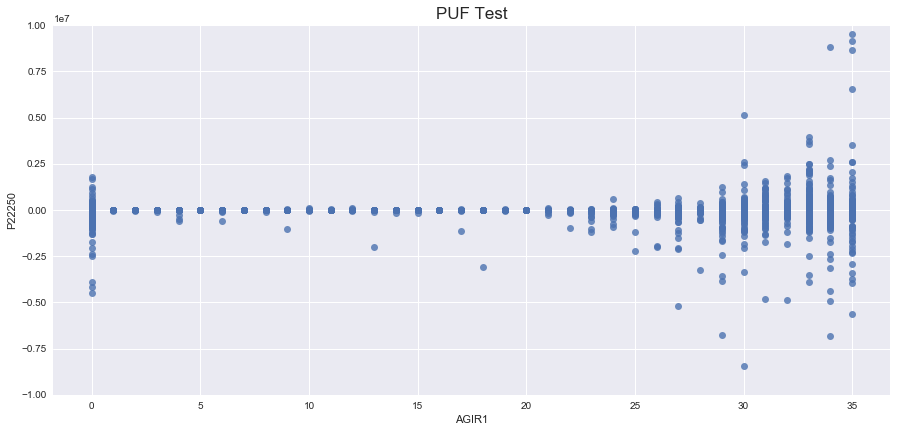

In [28]:
sns.set(color_codes=True)
plt.figure(figsize = (15, 6.8))
plt.title('PUF Test', fontsize = 17)
plt.ylim(-10000000, 10000000)
sns.regplot(data['AGIR1'], data['P22250'], fit_reg=False)

+/- 10,000,000 Predictions

Green lines on mnlogit plot indicate y-limits of next graph

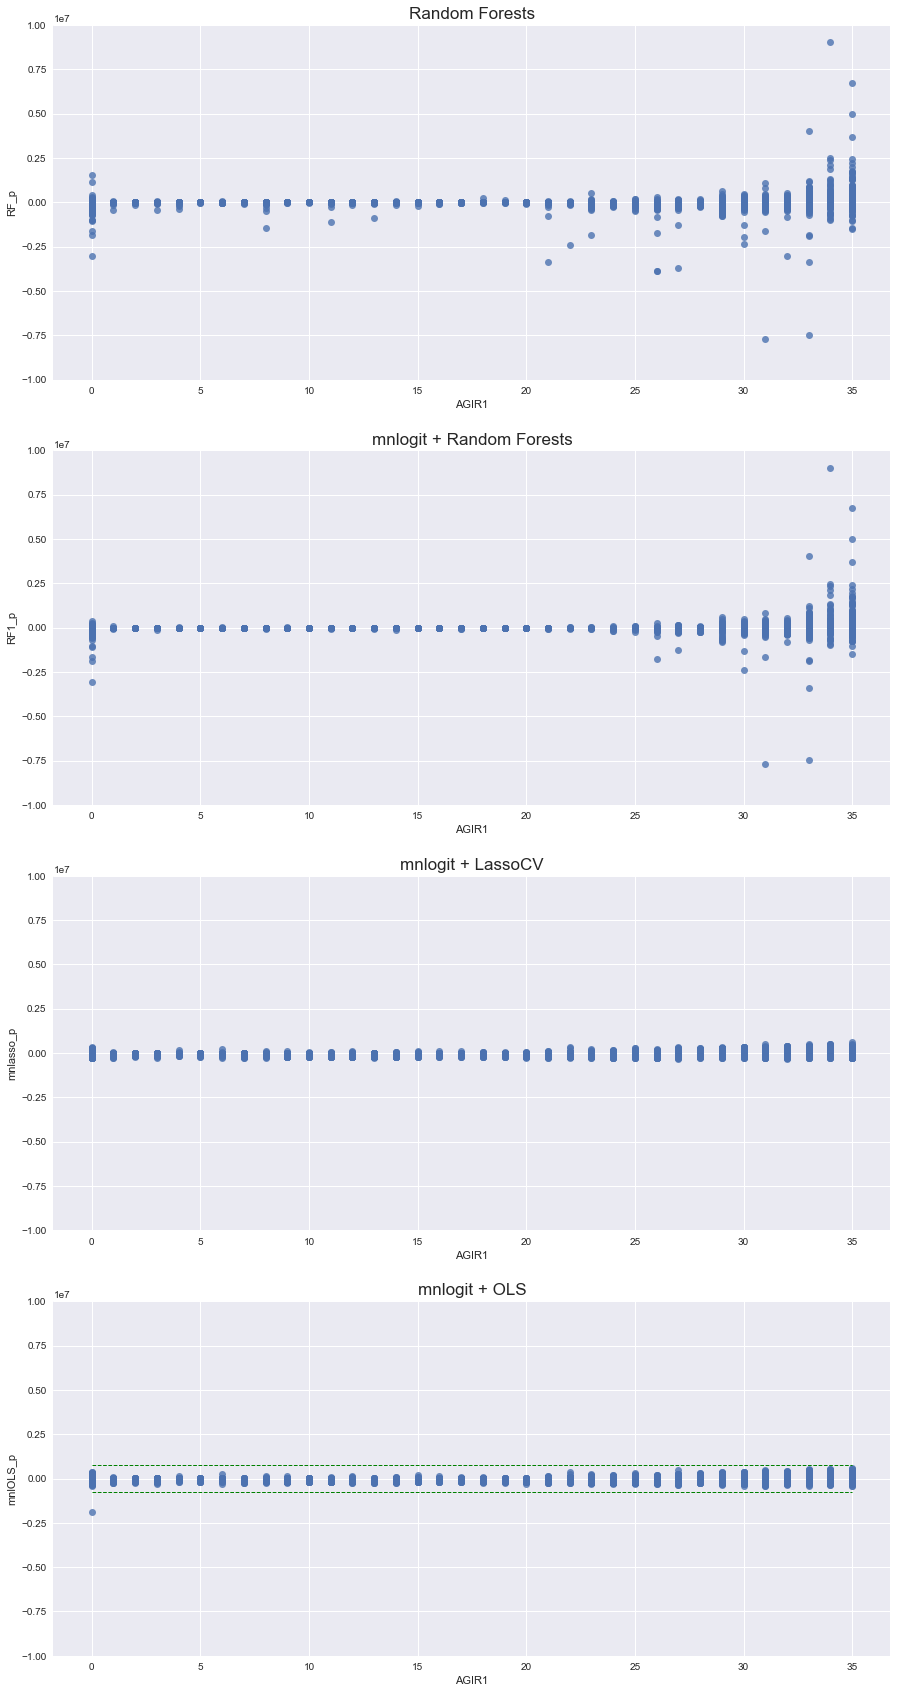

In [29]:
sns.set(color_codes=True)
plt.figure(figsize=(15,30))

plt.subplot(411)
plt.title('Random Forests', fontsize = 17)
plt.ylim(-10000000, 10000000)
sns.regplot(data['AGIR1'], data['RF_p'], fit_reg=False)

plt.subplot(412)
plt.title('mnlogit + Random Forests', fontsize = 17)
plt.ylim(-10000000, 10000000)
sns.regplot(data['AGIR1'], data['RF1_p'], fit_reg=False)

plt.subplot(413)
plt.title('mnlogit + LassoCV', fontsize = 17)
plt.ylim(-10000000, 10000000)
sns.regplot(data['AGIR1'], data['mnlasso_p'], fit_reg=False)

plt.subplot(414)
plt.title('mnlogit + OLS', fontsize = 17)
plt.ylim(-10000000, 10000000)
sns.regplot(data['AGIR1'], data['mnlOLS_p'], fit_reg=False)
plt.plot([0, 35], [750000, 750000], color='green', linestyle='dashed', linewidth=1)
plt.plot([0, 35], [-750000, -750000], color='green', linestyle='dashed', linewidth=1)

+/- 750,000 `test`

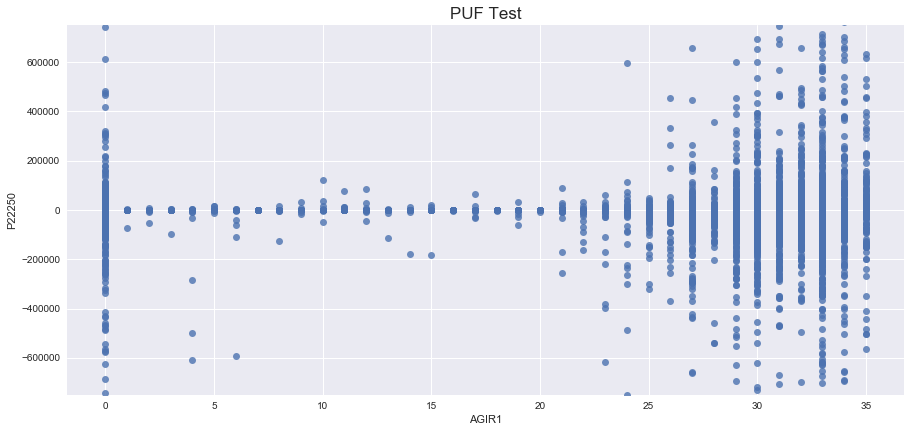

In [30]:
plt.figure(figsize = (15, 6.8))
plt.title('PUF Test', fontsize = 17)
plt.ylim(-750000, 750000)
sns.regplot(data['AGIR1'], data['P22250'], fit_reg=False)

+/- 750,000 Predictions

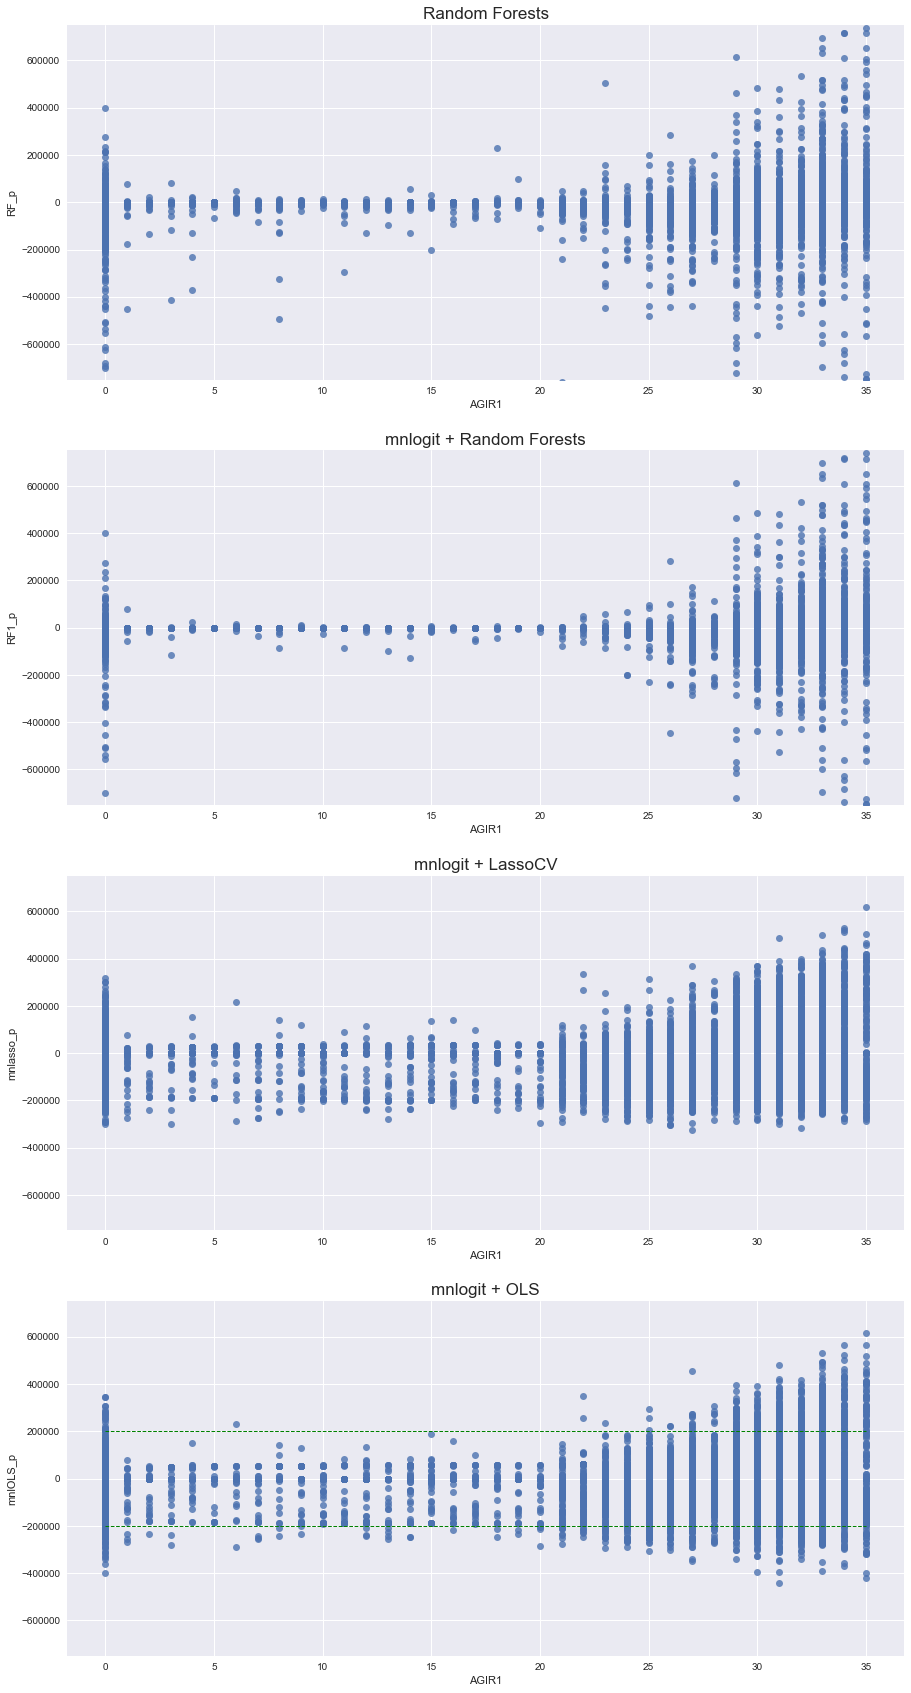

In [31]:
sns.set(color_codes=True)
plt.figure(figsize=(15,30))

plt.subplot(411)
plt.title('Random Forests', fontsize = 17)
plt.ylim(-750000, 750000)
sns.regplot(data['AGIR1'], data['RF_p'], fit_reg=False)

plt.subplot(412)
plt.title('mnlogit + Random Forests', fontsize = 17)
plt.ylim(-750000, 750000)
sns.regplot(data['AGIR1'], data['RF1_p'], fit_reg=False)

plt.subplot(413)
plt.title('mnlogit + LassoCV', fontsize = 17)
plt.ylim(-750000, 750000)
sns.regplot(data['AGIR1'], data['mnlasso_p'], fit_reg=False)

plt.subplot(414)
plt.title('mnlogit + OLS', fontsize = 17)
plt.ylim(-750000, 750000)
sns.regplot(data['AGIR1'], data['mnlOLS_p'], fit_reg=False)
plt.plot([0, 35], [200000, 200000], color='green', linestyle='dashed', linewidth=1)
plt.plot([0, 35], [-200000, -200000], color='green', linestyle='dashed', linewidth=1)

+/- 200,000 `test`

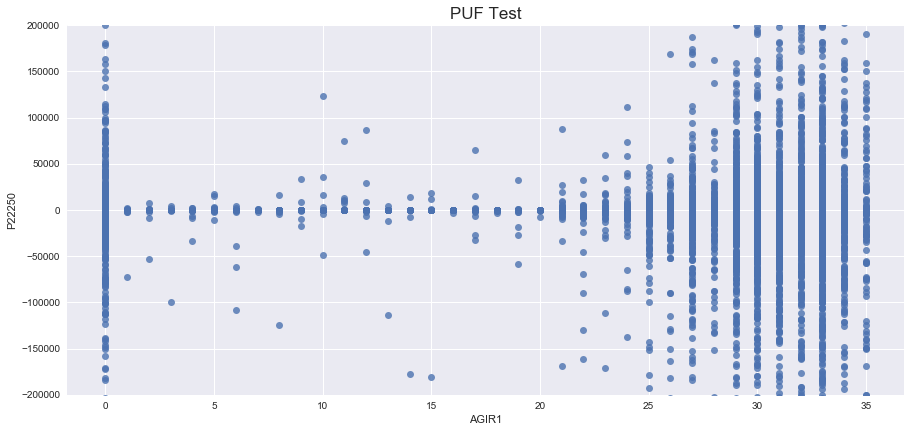

In [32]:
plt.figure(figsize = (15, 6.8))
plt.title('PUF Test', fontsize = 17)
plt.ylim(-200000, 200000)
sns.regplot(data['AGIR1'], data['P22250'], fit_reg=False)

+/- 200,000 Predictions

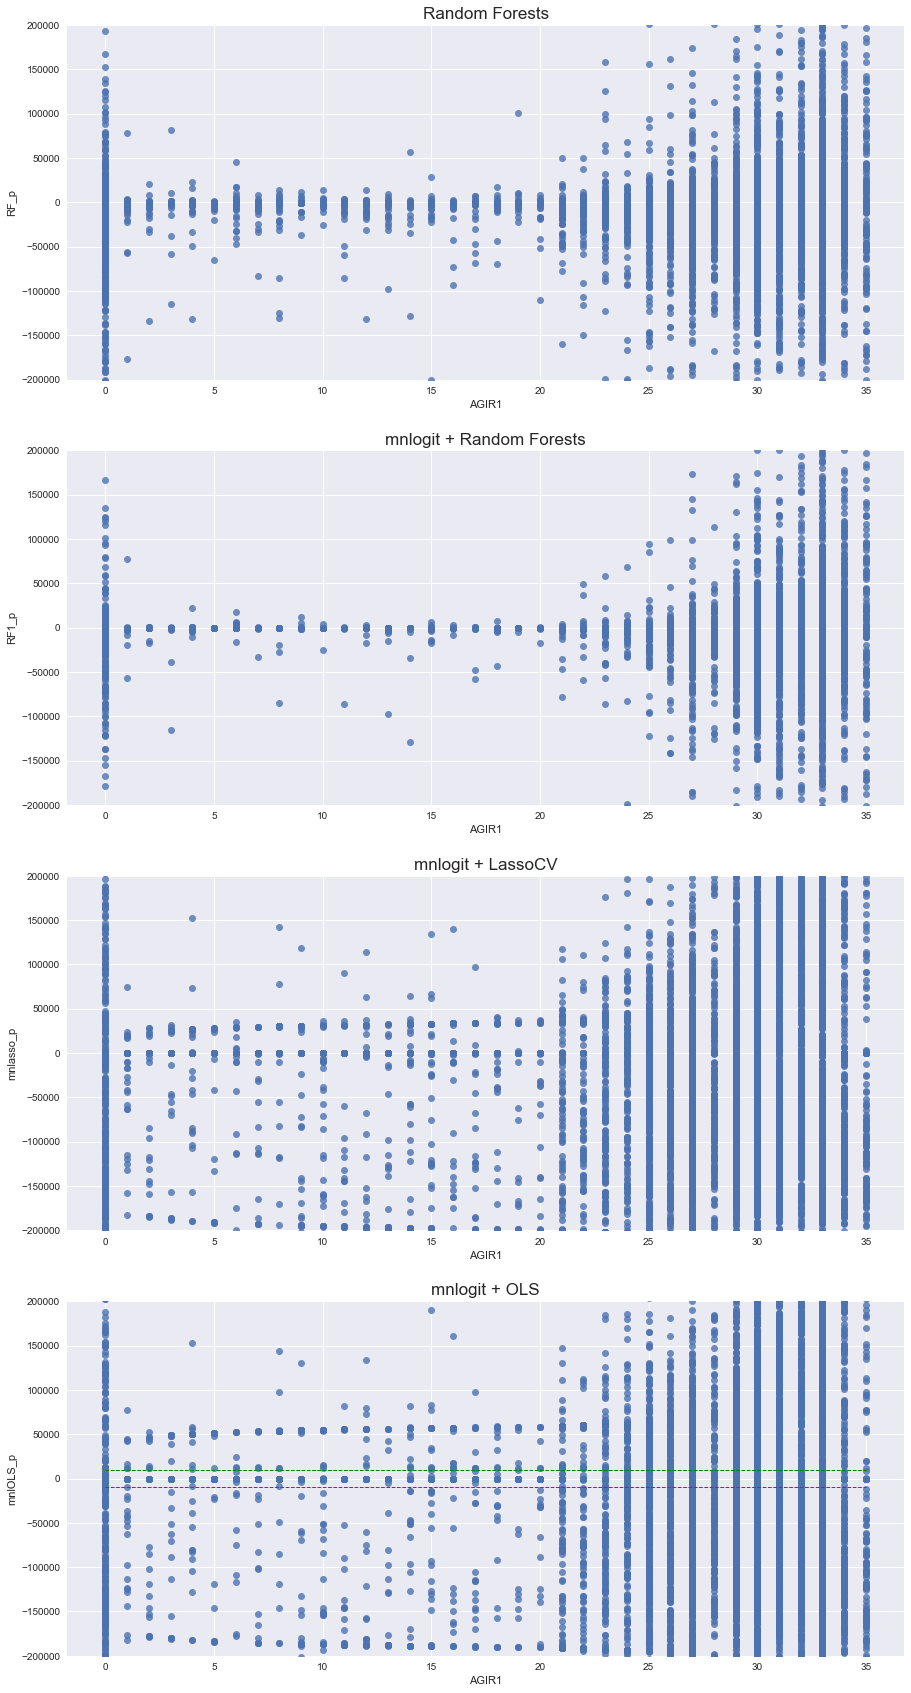

In [33]:
sns.set(color_codes=True)
plt.figure(figsize=(15,30))

plt.subplot(411)
plt.title('Random Forests', fontsize = 17)
plt.ylim(-200000, 200000)
sns.regplot(data['AGIR1'], data['RF_p'], fit_reg=False)

plt.subplot(412)
plt.title('mnlogit + Random Forests', fontsize = 17)
plt.ylim(-200000, 200000)
sns.regplot(data['AGIR1'], data['RF1_p'], fit_reg=False)

plt.subplot(413)
plt.title('mnlogit + LassoCV', fontsize = 17)
plt.ylim(-200000, 200000)
sns.regplot(data['AGIR1'], data['mnlasso_p'], fit_reg=False)

plt.subplot(414)
plt.title('mnlogit + OLS', fontsize = 17)
plt.ylim(-200000, 200000)
sns.regplot(data['AGIR1'], data['mnlOLS_p'], fit_reg=False)
plt.plot([0, 35], [10000, 10000], color='green', linestyle='dashed', linewidth=1)
plt.plot([0, 35], [-10000, -10000], color='green', linestyle='dashed', linewidth=1)